In [1]:
import ee
import geemap
import os
import numpy as np
import geopandas as gpd

In [2]:
os.getcwd()

'G:\\OneDrive\\casa0010dissertation\\00_06 jaipur code\\data_process'

In [3]:
import os
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code")

In [4]:
ee.Authenticate()

Enter verification code:  4/1AVMBsJgr41G4moXIjhvJxgbEiSuxwEKgBBsyzkaaUD2UJRBihKMLDmwoQCc



Successfully saved authorization token.


In [5]:
ee.Initialize()

In [7]:
# Define AOI
# Load the ward dataset

url = "data/raw/JMC_union.geojson"
wards = gpd.read_file(url)
# Check the current CRS
print("Original CRS:", wards.crs)
print("This is UTM Zone 43N for India - perfect for Jaipur!")

Original CRS: EPSG:32643
This is UTM Zone 43N for India - perfect for Jaipur!


In [8]:
# Convert to Earth Engine FeatureCollection
# geemap.geopandas_to_ee() will automatically handle the CRS conversion to WGS84
ee_wards = geemap.geopandas_to_ee(wards, geodesic=False)

In [9]:
# Get the geometry for AOI (union of all wards)
aoi = ee_wards.geometry()
print("AOI defined from Jaipur wards GeoJSON")

AOI defined from Jaipur wards GeoJSON


In [10]:
# Load GHSL Built-up Characteristics dataset
# GHSL data is from 2018 (latest available)
ghsl = ee.Image("JRC/GHSL/P2023A/GHS_BUILT_C/2018").select('built_characteristics').clip(aoi)

print("GHSL dataset loaded (2018 data)")

GHSL dataset loaded (2018 data)


In [11]:
# Create residential mask (classes 11-15 are residential buildings)
residential_mask = ghsl.gte(11).And(ghsl.lte(15))
print("Residential mask created (GHSL classes 11-15)")

Residential mask created (GHSL classes 11-15)


In [12]:
ghsl_residential = ghsl.updateMask(residential_mask)

In [13]:
Map = geemap.Map()
Map.addLayer(ghsl_residential, 
             {'min': 11, 'max': 15, 'palette': ['yellow', 'orange', 'red']}, 
             'GHSL Residential')
Map.centerObject(aoi, 10)
Map

Map(center=[26.89690137379895, 75.80202268095442], controls=(WidgetControl(options=['position', 'transparent_b…

In [15]:
# 2. Export settings (including coordinate transformation and resampling)
export_params = {
    'image': ghsl_residential,
    'description': 'GHSL_Residential_Classes_11_15_UTM43N',
    'folder': 'dissertation',
    'fileNamePrefix': 'ghsl_residential_100m_utm43n',
    'scale': 100,                
    'crs': 'EPSG:32643',        #jaipur projected CRS
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 1e9
}

# 3. Start the export
export_task = ee.batch.Export.image.toDrive(**export_params)
export_task.start()

CRS (投影): EPSG:32643
Width (列数): 223
Height (行数): 282
Number of Bands: 1
Data Type: uint8
Transform (空间变换): | 100.00, 0.00, 568300.00|
| 0.00,-100.00, 2989600.00|
| 0.00, 0.00, 1.00|
Min: 0
Max: 15
Mean: 3.2695989568425405


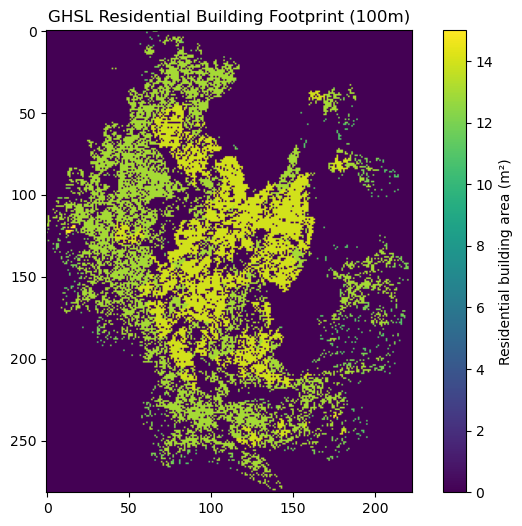

In [16]:
import rasterio
import matplotlib.pyplot as plt

# Read the file
raster_path = "data/raw/ghsl_residential_100m_utm43n.tif"

with rasterio.open(raster_path) as src:
    # View basic information
    print("CRS :", src.crs)
    print("Width :", src.width)
    print("Height :", src.height)
    print("Number of Bands:", src.count)
    print("Data Type:", src.dtypes[0])
    print("Transform :", src.transform)

    # Read data from the first band
    band1 = src.read(1)

# View basic statistical information of pixel values
print("Min:", band1.min())
print("Max:", band1.max())
print("Mean:", band1.mean())

# Visualize the first 1000x1000 region (to avoid the entire image being too large)
plt.figure(figsize=(8, 6))
plt.imshow(band1[:1000, :1000], cmap='viridis')
plt.title('GHSL Residential Building Footprint (100m)')
plt.colorbar(label='Residential building area (m²)')
plt.show()


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Read the file
raster_path = "data/raw/ghsl_residential_100m_utm43n.tif"

with rasterio.open(raster_path) as src:
    # View basic information
    print("CRS :", src.crs)
    print("Width :", src.width)
    print("Height :", src.height)
    print("Number of Bands:", src.count)
    print("Data Type:", src.dtypes[0])
    print("Transform :", src.transform)

    # Read data from the first band
    band1 = src.read(1)

# View basic statistical information of pixel values
print("Min:", band1.min())
print("Max:", band1.max())
print("Mean:", band1.mean())

# Visualize the first 1000x1000 region (to avoid the entire image being too large)
plt.figure(figsize=(8, 6))
plt.imshow(band1[:1000, :1000], cmap='viridis')
plt.title('GHSL Residential Building Footprint (100m)')